In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import gzip

In [11]:
def query(url, data, mode):
    match mode:
        case 'POST':
            item = requests.post(url,json=data)
            item = json.loads(item.content.decode())
        case 'GET':
            item = requests.get(url)
            item = json.loads(item.content.decode())
    return item

In [9]:
from sklearn.metrics                 import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.pipeline                import make_pipeline
from sklearn.decomposition           import TruncatedSVD
from sklearn.preprocessing           import Normalizer
from sklearn.cluster                 import KMeans

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

In [3]:
import numpy as np

In [7]:
url  = "http://127.0.0.1:5000/get_descs"
    
data = query(url = url, data = None, mode = 'GET')
IDS, desc = zip(*data)
IDS, documents = np.array(IDS), np.array(desc)

In [13]:
def kmeans_tune(X_lsa, n_clusters_max = 15,trials = 5) -> list[float]:
    results = []
    for n_clusters in range(2,n_clusters_max):
        c_score = 0
        for seed in range(trials):
            kmeans = KMeans(
                max_iter     = 100,
                n_clusters   = n_clusters,
                n_init       = 10,
                random_state = seed,
            ).fit(X_lsa)
            c_score += silhouette_score(X_lsa,kmeans.labels_)

        c_score /= trials
        results.append(float(c_score))
        # cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
        # print(f"Number of elements assigned to each cluster: {cluster_sizes}")
    return results

In [14]:
X_lsa = lsa_vectorizer.fit_transform(documents)
results = kmeans_tune(X_lsa, trials=50)

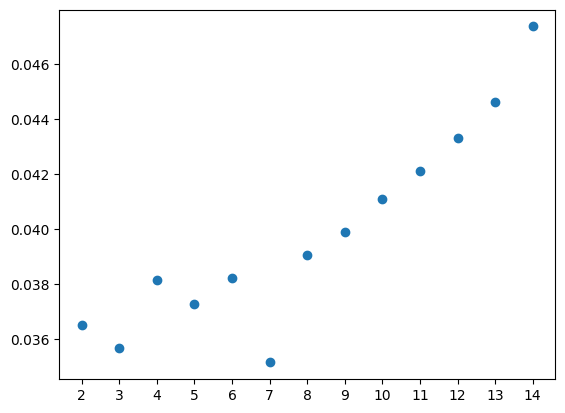

In [15]:
plt.scatter( y= results,x = [i + 2 for i in range(len(results))])
plt.xticks([i + 2 for i in range(len(results))])
plt.show()

In [16]:
import numpy as np

In [17]:
idx  = np.argmin(results)
print(idx)
results[idx]

5


0.03515298791482557

In [ ]:
def best_k(results: list, cutoff = 0.98):
    difference = []
    for idx in range(1,len(results)):
        diff = results[idx] - results[idx - 1]
        difference.append(diff)

    total = 0
    diff_total = sum(diff)
    values = [d/diff_total for d in diff]
    for idx, val in enumerate(values):
        total += val
        if total >= cutoff:
            return (idx + 2)

In [19]:
kmeans = KMeans(
        max_iter     = 100,
        n_clusters   = idx + 2,
        n_init       = 5,
        random_state = 42,
    ).fit(X_lsa)

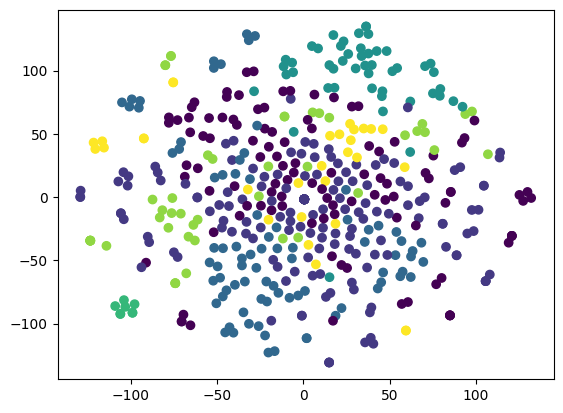

In [20]:
from sklearn.manifold import TSNE 

enc  = TSNE(n_components=2, random_state=42)
cord = enc.fit_transform(X_lsa)
plt.scatter(x = cord[:,0], y = cord[:,1], c= kmeans.labels_)
plt.show()

In [12]:
clusters = [(kmeans.labels_[idx], d) for idx, d in enumerate(documents)]

In [22]:
from collections import Counter

In [28]:
Counter(list(documents)) + Counter(list(documents))

Counter({np.str_(''): 58,
         np.str_('Geekdom Workshop Wednesday – Details Coming Soon! About This Event: Join us for another exciting event at Geekdom! Each week, we bring together entrepreneurs, innovators, and industry experts to...'): 16,
         np.str_('Get ready to sweat, dance, and have a blast in Kiki’s high-energy Zumba class! Zumba combines Latin and international music with dance moves to create a dynamic and fun workout […]'): 10,
         np.str_('In today’s rapidly changing education landscape, teachers can count on CEA for up-to-date information, essential resources, and the support they need to navigate new challenges.'): 8,
         np.str_("Let's game together! Have Pokémon battles with friends with Pokken Tournament, racing in Mario Kart 8, or Battle in Super Smash Bros! AGE GROUP: | Kids | EVENT TYPE: | Games & Activities | Game..."): 8,
         np.str_('This is a yard sale prep meeting at Kathy Torg’s house. The focus will be on sorting, measuring and pric